In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint
import time
from jax import jit

import inputools.Trajectory as it
from tools.evolutions import load_best_individual
import src.models as mm
from src.models import logger
import src.visualizations as mv
import src.agents as agents
import src.torch_models as tm

from tools.utils import clf, tqdm_enumerate, save_image

%load_ext autoreload
%autoreload 2

plt.style.use('classic')
logger()

2024-03-11 23:15:38 | 


This notebook is about the study of active navigation by exploiting a formed place cell layer.

## hard-coded PC layer 
---

#### Trajectory

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 109685.12it/s]


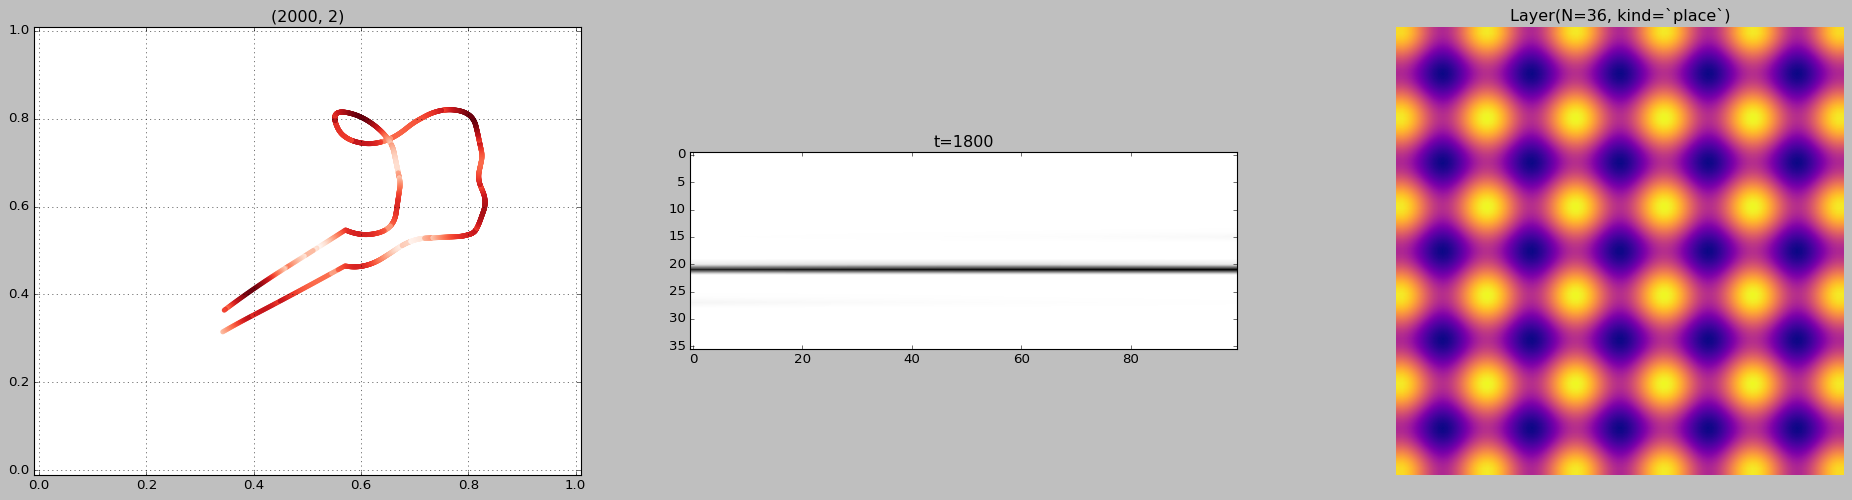

In [12]:
# input
duration = 2
speed = 5e-1
dt = 1e-1
Nj = 6**2
sigma = 0.01

trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200, dim=2) * 0.7 + 0.15

#layer = it.HDLayer(N=5**2, sigma=0.01)
layer = it.PlaceLayer(N=Nj, sigma=sigma)

A = layer.parse_trajectory(trajectory=trajectory)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
z = np.zeros(len(A))
for i in range(len(A[0])):
    z += np.where(A[:, i] > 0.1, A[:, i], 0)

ax1.scatter(trajectory[:, 0], trajectory[:, 1], c=z, s=20, cmap='Reds',
           edgecolors='black', linewidths=0)
ax1.set_ylim((-0.01, 1.01))
ax1.set_xlim((-0.01, 1.01))
ax1.grid()
ax1.set_title(trajectory.shape)

for t in range(0, len(A)-100, 100):
    ax2.imshow(A[t:t+100, :].T, cmap='Greys')
    ax2.set_title(f"{t=}")
    
layer.plot(size=100, kind='imshow', sigmoid_beta=0.01, sigmoid_alpha=0., ax=ax3)

In [80]:
agent = agents.AgentPC(Npc=5**2, Nh=10, start_position=trajectory[0], step_size=0.0001, activation='sigmoid')
agent(goal_position=trajectory[t].copy().reshape(-1, 1))


array([0.50038672, 0.50025293])

In [79]:
agent.layer_pc.centers.T @ agent.pc_post_a / agent.pc_post_a.sum()

array([[0.50016565],
       [0.49972521]])

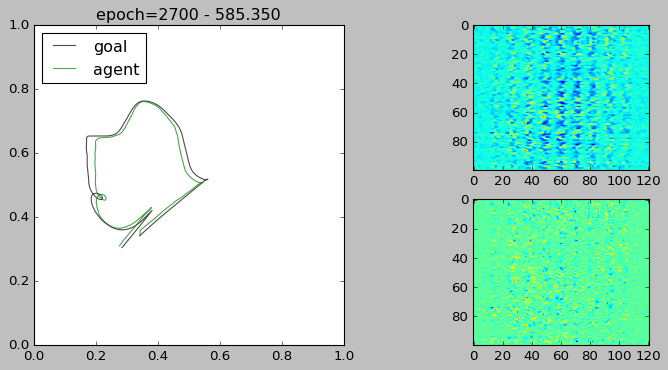

KeyboardInterrupt: 

In [13]:
""" initialization """

npc = 11
agent = agents.AgentPC(Npc=npc**2, Nh=100, start_position=trajectory[0].copy(), lr=-0.005, sigma_pc=0.02,
                       activation='relu', activation_out='relu')
logger(agent)

agents.DEBUG = bool(0)
pflag = -1 if agents.DEBUG else 0
epochs = 5000
epoch_log = int(max((epochs*0.02, 1)))
looksteps = 2
new_trj = 100
for epoch in range(epochs):

    # new trajectory are periodically created
    if epoch % new_trj == 0:
        trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200, dim=2) * 0.7 + 0.15

    # init
    agent.set_position(position=trajectory[0].copy().reshape(-1, 1))
    positions = np.zeros((trajectory.shape[0]-looksteps-1, trajectory.shape[1]))
    positions[0] = trajectory[0].copy()
    loss = 0.

    # train
    for t in range(1, len(trajectory)-looksteps-1):
        positions[t] = agent(goal_position=trajectory[t+looksteps].copy().reshape(-1, 1))
        loss += agent.update(target_position=trajectory[t+looksteps+1].copy().reshape(-1, 1))

        if agents.DEBUG:
            print('##########################')
            clf()
            input()
            plt.subplot(121)
            plt.imshow(agent.goal_pc.reshape(npc, npc))
            plt.grid()
            plt.subplot(122)
            plt.imshow(agent.current_pc.reshape(npc, npc))
            plt.grid()
            plt.show()
            if t == 100: break
            
    #print(positions, end=' ')

    if epoch % epoch_log == pflag:

        clf()
        plt.figure(figsize=(11, 5))
        plt.subplot(121)
        plt.plot(trajectory[:, 0], trajectory[:, 1], '-k', alpha=0.7, label="goal")
        plt.plot(positions[:, 0], positions[:, 1], '-g', alpha=0.7, label="agent")
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.legend(loc="upper left")
        plt.title(f"{epoch=} - {loss:.3f}")

        plt.subplot(222)
        plt.imshow(agent.Wh)

        plt.subplot(224)
        plt.imshow(agent.Wout.T)
        plt.pause(0.0001)

#### Test

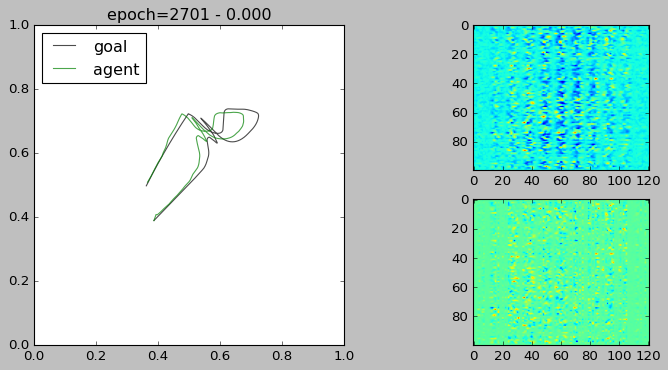

In [30]:
""" settings """
duration = 2
speed = 5e-1
dt = 1e-1

trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200, dim=2) * 0.5 + 0.25

""" run """
agent.set_position(position=trajectory[0].copy().reshape(-1, 1))
positions = np.zeros((trajectory.shape[0]-looksteps, trajectory.shape[1]))
positions[0] = trajectory[0].copy()
loss = 0.
for t in range(1, len(trajectory)-looksteps):
    positions[t] = agent(goal_position=trajectory[t+looksteps].copy().reshape(-1, 1))

""" plot """
plt.figure(figsize=(11, 5))
plt.subplot(121)
plt.plot(trajectory[:, 0], trajectory[:, 1], '-k', alpha=0.7, label="goal")
plt.plot(positions[:, 0], positions[:, 1], '-g', alpha=0.7, label="agent")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend(loc="upper left")
plt.title(f"{epoch=} - {loss:.3f}")

plt.subplot(222)
plt.imshow(agent.Wh)

plt.subplot(224)
plt.imshow(agent.Wout.T)
plt.show()

## HLayer

#### From sim_hl_1 (evolution)

2024-02-24 23:38:39 | Whole track, shape=(10201, 2)
2024-02-24 23:38:40 | Trajectory shape=(10000, 2)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10201/10201 [00:00<00:00, 20242.61it/s]
2024-02-24 23:38:43 | max=0.9758007456809276
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.94it/s]


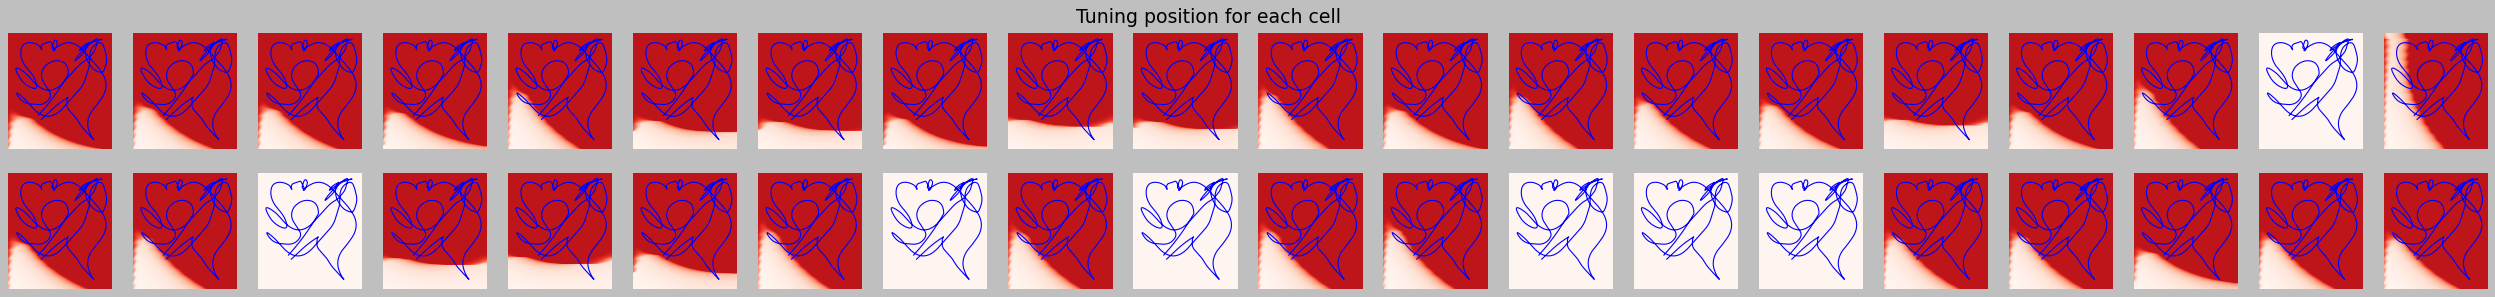

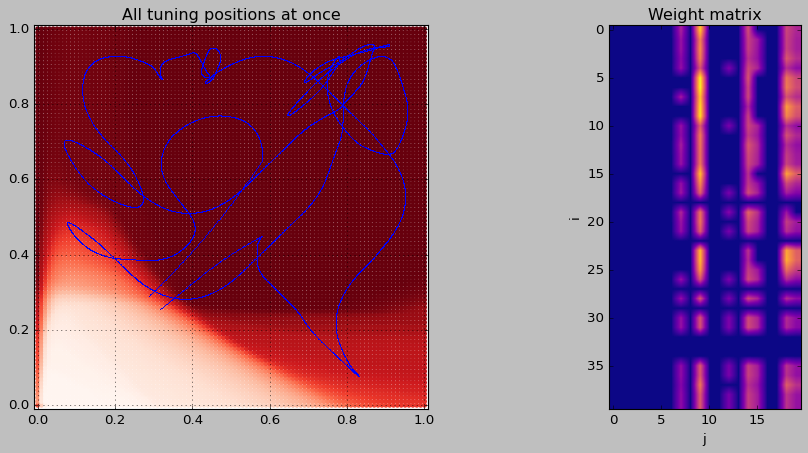

In [28]:
""" load """
record_ind = load_best_individual()
genome = record_ind['genome']
clf()

""" settings from record """
duration = 10
dt = 1e-3
speed = 1e-2
prob_turn = 0.004
k_average = 300

""" Model initialization """

model = hl.ModelHL(W=genome['W'], B=genome['B'], activation=genome['activation'])
N = hl.PCNN_PARAMS['N']

""" Creation of the data """

whole_track = it.make_whole_walk(dx=0.01)

logger(f"Whole track, shape={whole_track.shape}")

trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=prob_turn, k_average=k_average)

logger(f"Trajectory shape={trajectory.shape}")

""" Run """
for t, x in tqdm_enumerate(trajectory):
    model.step(x=x.reshape(-1, 1))

""" test on the entire environment """
record = np.empty((N, len(whole_track)))
model.set_off()

for t, x in tqdm_enumerate(whole_track):
    model.step(x=x.reshape(-1, 1))   
    record[:, t] = model.pcnn.u.flatten()

logger.debug(f"max={record[0].max()}")

""" pre-process activations """
#z = np.zeros(record.shape[1])
#for i in range(model.N):
    #if i > 7: break
    #if record[i].max() > 0.99: continue
    #z += np.where(record[i] > 0., record[i], 0)

#z = z.clip(0, 0.8) 
record = np.clip(record, 0, 0.8)
z = np.where(record < 0.05, 0, record).sum(axis=0)
z = (z.max() - z)/(z.max() - z.min())

record[:, 0] = 1

""" plot each cell's preferred location over the trajectory """

ncols = N // 2
fig_1, axs = plt.subplots(2, ncols, figsize=(ncols*2, 4))
i = 0
for row in tqdm(axs):
    for ax in row:
        ax.plot(trajectory[:, 0], trajectory[:, 1])
        ax.scatter(whole_track[:, 0], whole_track[:, 1], c=record[i], s=100, cmap='Reds',
           edgecolors='black', linewidths=0)
        ax.axis('off')
        ax.set_ylim((-0.01, 1.01))
        ax.set_xlim((-0.01, 1.01))
        i += 1
plt.suptitle("Tuning position for each cell", fontsize=17)
plt.show()

""" plot all cells at the same time """

fig_2, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 6))

# --> plot activity over the trajectory
ax1.plot(trajectory[:, 0], trajectory[:, 1], ',b', markersize=5)

#plt.scatter(whole_track[:, 0], whole_track[:, 1], c=record[7], s=20, cmap='Reds')
ax1.scatter(whole_track[:, 0], whole_track[:, 1], c=z, s=20, cmap='Reds_r',
           edgecolors='black', linewidths=0)

ax1.set_ylim((-0.01, 1.01))
ax1.set_xlim((-0.01, 1.01))
ax1.grid()
ax1.set_title(f"All tuning positions at once")
#ax1.scatter(whole_track[:, 0], whole_track[:, 1], c=whole_track_pc.sum(axis=1), cmap='Greys', edgecolors='white', alpha=0.3)

# --> plot the weight matrix
ax2.imshow(model.pcnn.W_final, cmap='plasma')
#score2 = hl.eval_information_II_hl(model=model, trajectory=trajectory, whole_trajectory=whole_track)
ax2.set_title(f"Weight matrix")
ax2.set_xlabel('j')
ax2.set_ylabel('i')

plt.show()


## Autoencoder
---
**encoding of the input position + boundary distance**

it can work, yes

In [ ]:
""" settings from record """
duration = 10
dt = 1e-3
speed = 1e-2
prob_turn = 0.004
k_average = 300


""" Creation of the data """

whole_track_1 = trajectory=it.make_whole_walk(dx=0.05)

# option 1) direct border input
whole_track = tm.calc_input_trajectory(whole_track_1).reshape(-1, 6)

# option 2) grid + border input
layer = it.InputNetwork(layers=[it.BorderLayer(N=4*2, sigma=0.01), 
                                it.GridLayer(N=10, Nz=0, sigma=8,
                                            scale=np.array([1.1, 1.]))
                                ])
#whole_track = layer.parse_trajectory(trajectory=whole_track_1)

logger(f"Whole track, shape={whole_track.shape}")

""" Model initialization """
N = layer.N
N = 6
model = tm.Autoencoder(input_dim=N, hidden_dims=[10, 20, 40])

""" Run """

model, losses = tm.train_autoencoder(input_array=whole_track.copy(), epochs=50_000, model=model, lr=1e-3, alpha=1e-3)

""" Plot """
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

2024-02-26 02:21:21 | Whole track, shape=(441, 6)
Epoch: 6304, Loss: 0.259244:  13%|███████▉                                                       | 6271/50000 [00:08<01:00, 726.85it/s]

In [12]:
whole_track.shape

(10201, 18)

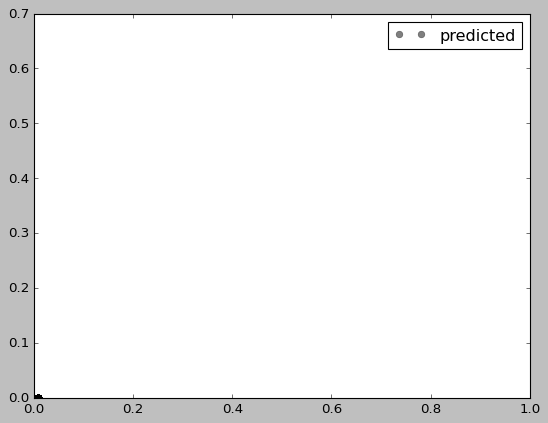

In [13]:
y = tm.generate(model=model, input_array=whole_track.copy())

cut = 10000
#plt.plot(whole_track[:cut, 0], whole_track[:cut, 1], 'go', label='true', alpha=0.5)
plt.plot(y[:cut, 0], y[:cut, 1], 'ko', label='predicted', alpha=0.5)
plt.xlim((0., 1))
plt.ylim((0., 0.7))
plt.legend()
plt.show()

In [7]:
layer = it.InputNetwork(layers=[it.BorderLayer(N=4*2, sigma=0.01), 
                                   it.GridLayer(N=10, Nz=0, sigma=8,
                                                scale=np.array([1.1, 1.]))
                                  ])
layer.N

18

#### Save

In [42]:
torch.save(model.state_dict(), 'src/torch_models/autoenc_state_dict_1.pth')
logger()

NameError: name 'torch' is not defined

In [89]:
# Assuming the hidden dimensions and input dimension are the same as the ones used for the Autoencoder
encoder_model = tm.Encoder(input_dim=6, hidden_dims=[15, 30])

# load
loaded_model = torch.load('src/torch_models/autoenc_state_dict_1.pth')

# Filter to keep only encoder parameters; no further state_dict() calls on state_dict object
encoder_state_dict = {key: value for key, value in loaded_model.items() if key.startswith('encoder')}

encoder_model.load_state_dict(encoder_state_dict)

# Set the encoder model to evaluation mode if you are planning to use it for inference directly
encoder_model.eval()


Encoder(
  (encoder): ModuleList(
    (0): Linear(in_features=6, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=30, bias=True)
  )
)

In [43]:
hl.load_encoder(path='src/torch_models/autoenc_state_dict_1.pth')

Encoder(
  (encoder): ModuleList(
    (0): Linear(in_features=6, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=30, bias=True)
  )
)

## CNN
---
**training on connectivity matrix -> angle**

In [31]:
""" Creation of the data """

input_data = np.random.binomial(1, 0.1, size=(100, 1, 60, 60))  # (batch_size, channels, height, width)

logger(f"{input_data.shape=}")


""" Model initialization """
model = tm.ConvAutoencoder(hidden_dims=[120, 90])

""" Run """
model, losses = tm.train_autoencoder(input_array=input_data, epochs=10_000, model=model, 
                                     lr=5e-3, loss_fn=hl.F.mse_loss, epoch_log=0.005)

""" Plot """
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

2024-02-27 01:34:10 | input_data.shape=(100, 1, 60, 60)
Epoch: 1151, Loss: 0.099150:  12%|██████████████████▊                                                                                                                                            | 1185/10000 [07:34<56:22,  2.61it/s]


KeyboardInterrupt: 

In [25]:
3872/32

121.0

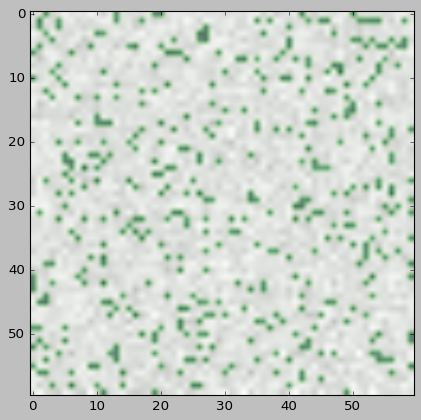

In [30]:
""" generation """
x = input_data[1].reshape(1, 1, 60, 60)
z = np.random.binomial(1, 0.01, size=(1, 1, 60, 60))
y = tm.generate(model=model, input_array=x)[0, 0]

#plt.plot(whole_track[:cut, 0], whole_track[:cut, 1], 'go', label='true', alpha=0.5)

plt.imshow(y, cmap='Greys', alpha=0.5)
plt.imshow(x[0, 0], cmap='Greens', alpha=0.5)

plt.show()

In [80]:
""" save """
tm.save_model(model=model, name="convautoenc_1", path=r"src/torch_models/")

2024-02-26 23:21:28 | Model saved at `src/torch_models/convautoenc_1.pt`


In [91]:
""" make encoder """
model = tm.load_autoencoder(path='src/torch_models/conv_autoencoder_1.pt', kind='ConvAutoencoder')
model

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=7200, out_features=40, bias=True)
    (6): ReLU()
    (7): Linear(in_features=40, out_features=40, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=7200, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(32, 15, 15))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU()
  )
)

In [87]:
""" make encoder """
encoder = tm.load_encoder(path='src/torch_models/convautoenc_1.pt', kind='ConvEncoder')
encoder

[120, 40]


ConvEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=7200, out_features=120, bias=True)
    (6): ReLU()
    (7): Linear(in_features=120, out_features=40, bias=True)
    (8): ReLU()
  )
)

In [88]:
encoder(hl.torch.randn(1, 1, 60, 60))

tensor([[0.1049, 0.0000, 0.0000, 0.0376, 0.0587, 0.0000, 0.0000, 0.0000, 0.0103,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0097, 0.0107, 0.0024, 0.0217,
         0.0432, 0.0700, 0.0609, 0.1377, 0.0000, 0.0326, 0.0243, 0.0451, 0.0000,
         0.0395, 0.0737, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0141, 0.0427, 0.1139, 0.1004]], grad_fn=<ReluBackward0>)

## Big CRL model
---

In [113]:
cd = tm.CustomDataset(name='dataset_1')
#model = tm.TrajectoryGenerator(context_size=100, hidden_size=100, num_layers=10, seq_len=cd.seq_len)
model = tm.CRLmodel()

logger(cd)
logger(model)

2024-02-28 01:21:55 | CustomDataset(name=dataset_1, keys_len=50)
2024-02-28 01:21:55 | CustomDataset(name=dataset_1, keys_len=50)
2024-02-28 01:21:55 | CRLmodel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (rnn1): RNN(128, 100, num_layers=2, batch_first=True)
  (fc_final): Linear(in_features=100, out_features=100, bias=True)
)
2024-02-28 01:21:55 | CRLmodel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): M

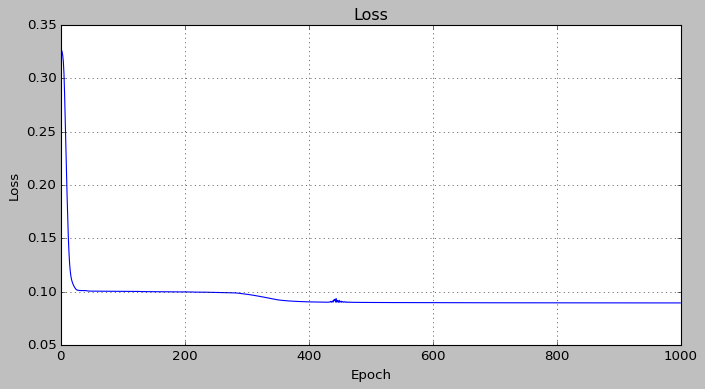

In [123]:
#model, losses = tm.train_model(dataset=cd, model=model, epochs=100, epoch_log=0.01)

""" Plot """
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)
plt.show()

In [25]:
tm.simulate_crl(name="crl_1", dataset_name='dataset_1',
             hidden_dims=[256, 128], recurrent_nodes=100,
             epochs=5, epoch_log=1, lr=1e-3, 
             save=False, data_path='PCNN/cache')


2024-02-28 05:00:07 | Simulation `CRL`
2024-02-28 05:00:07 | DEVICE=device(type='cpu')
2024-02-28 05:00:07 | /Users/daniekru/Research/lab
2024-02-28 05:00:08 | CustomDataset(name=dataset_1, keys_len=500)
2024-02-28 05:00:08 | CRLmodel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (rnn1): RNN(128, 100, num_layers=2, batch_first=True)
  (fc_final): Linear(in_features=100, out_features=100, bias=True)
)
Epoch: 5, Loss: 0.010868: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.51s/it]


## DNN-PC
---

#### Utils

In [14]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(int)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sx = sigmoid(x)
    return sx * (1 - sx)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

def get_activation_function(activation_name):
    if activation_name == 'relu':
        return relu, relu_derivative
    elif activation_name == 'sigmoid':
        return sigmoid, sigmoid_derivative
    elif activation_name == 'tanh':
        return tanh, tanh_derivative
    else:
        # Assuming 'linear' as the default case
        return linear, linear_derivative


def heatmap(metric, N=10, du=1e-2):

    V = np.empty((N, N))
    for i, x in enumerate(np.linspace(0, 1, N)):
        for j, y in enumerate(np.linspace(0, 1, N)):
            # flip wrt y axis
            V[N-1-i, N-1-j] = np.linalg.det(metric(x,y))#((metric(x, y) @ np.array([[x], [y]])).T @ np.array([[x+du], [y]])).item()

    plt.imshow(V)
    plt.axis('off')
    plt.colorbar()
    plt.show()

def heatmap2(metric, N=10, du=1e-2):

    V = np.empty((4, N, N))
    for i, x in enumerate(np.linspace(0, 1, N)):
        for j, y in enumerate(np.linspace(0, 1, N)):
            # flip wrt y axis
            m = metric(x,y)
            V[0, N-1-i, N-1-j] = m[0, 0]
            V[1, N-1-i, N-1-j] = m[0, 1]
            V[2, N-1-i, N-1-j] = m[1, 0]
            V[3, N-1-i, N-1-j] = m[1, 1]


    vmin = V.min()
    vmax = V.max()

    #plt.suptitle(f"g={m}")
    plt.subplot(221)
    plt.imshow(V[0], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("$g_{ii}$")
    plt.axis('off')
    
    plt.subplot(222)
    plt.imshow(V[1], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("$g_{ji}$")
    plt.axis('off')
    
    plt.subplot(223)
    plt.imshow(V[2], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("$g_{ij}$")
    plt.axis('off')
    
    plt.subplot(224)
    plt.imshow(V[3], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("$g_{jj}$")
    plt.axis('off')
    
    plt.show()

""" load model params """
def make_g(model, actp, act):
    wdict = model.state_dict()
    w1 = wdict['layers.0.weight'].numpy()
    b1 = wdict['layers.0.bias'].numpy().reshape(-1, 1)
    w2 = wdict['layers.1.weight'].numpy()
    b2 = wdict['layers.1.bias'].numpy().reshape(-1, 1)
    
    print(f"{w1.shape=}")
    print(f"{w2.shape=}")
    
    
    """ metric calc """
    
    def G(x, y, w1=w1, w2=w2, b1=b1, b2=b2):
    
        x1 = np.array([[x], [y]])    
        x2 = w1 @ x1 + b1
        x3 = w2 @ act(x2) + b2
    
        return ((actp(x2).T @ w1).T @ (actp(x3).T @ w2)) @ ((actp(x2).T @ w1).T @ (actp(x3).T @ w2)).T
        #return ((actp(x3) * w2) @ (actp(x2) * w1)).T @ ((actp(x3) * w2) @ (actp(x2) * w1)).T
        #return np.around(((actp(x2) @ (actp(x3).T @ w2)) @ w1).T @ ((actp(x2) @ (actp(x3).T @ w2)) @ w1), 3)
    
    print(np.around(G(x=1, y=1.))) 
    
    #_ = transform_variable_grid(G, bounds=(-1, 1, -1, 1), nlines=30)
    heatmap2(G)


#### train new model

In [7]:
""" settins """

nj = 8
Nj = nj**2
layer = it.PlaceLayer(N=Nj, sigma=0.01)

""" data """

input_array = it.make_whole_walk(dx=0.01)
target_array = layer.parse_trajectory(trajectory=input_array)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10201/10201 [00:00<00:00, 115957.45it/s]


In [18]:
""" traininig """
activation = 'sigmoid'
act, actp = get_activation_function(activation)

model = tm.DNN(hidden_dims=[32, 32, Nj], activation=activation)

model, losses, preds = tm.train_dnn(input_array=input_array.copy(),
                             target_array=target_array.copy(),
                             model=model, epochs=10_000)

Epoch: 9001, Loss: 0.006535: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 226.81it/s]
2024-03-11 23:22:25 | Final loss: 0.002574


**Save model**

#### load model

#### visualize

In [1490]:
k = int(np.sqrt(len(target_array)))
i = 0
k

101

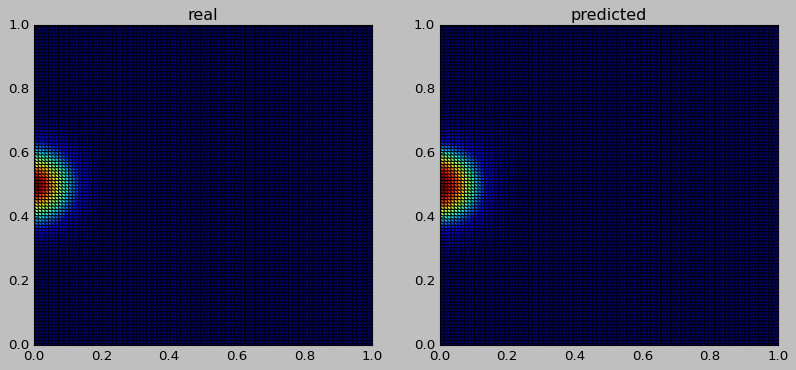

In [1493]:
i += 1

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(input_array[:, 0], input_array[:, 1], c=target_array[:, i])
plt.title("real")

plt.xlim((0, 1))
plt.ylim((0, 1))

plt.subplot(122)
plt.scatter(input_array[:, 0], input_array[:, 1], c=preds[:, i])

plt.title("predicted")

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.21it/s]


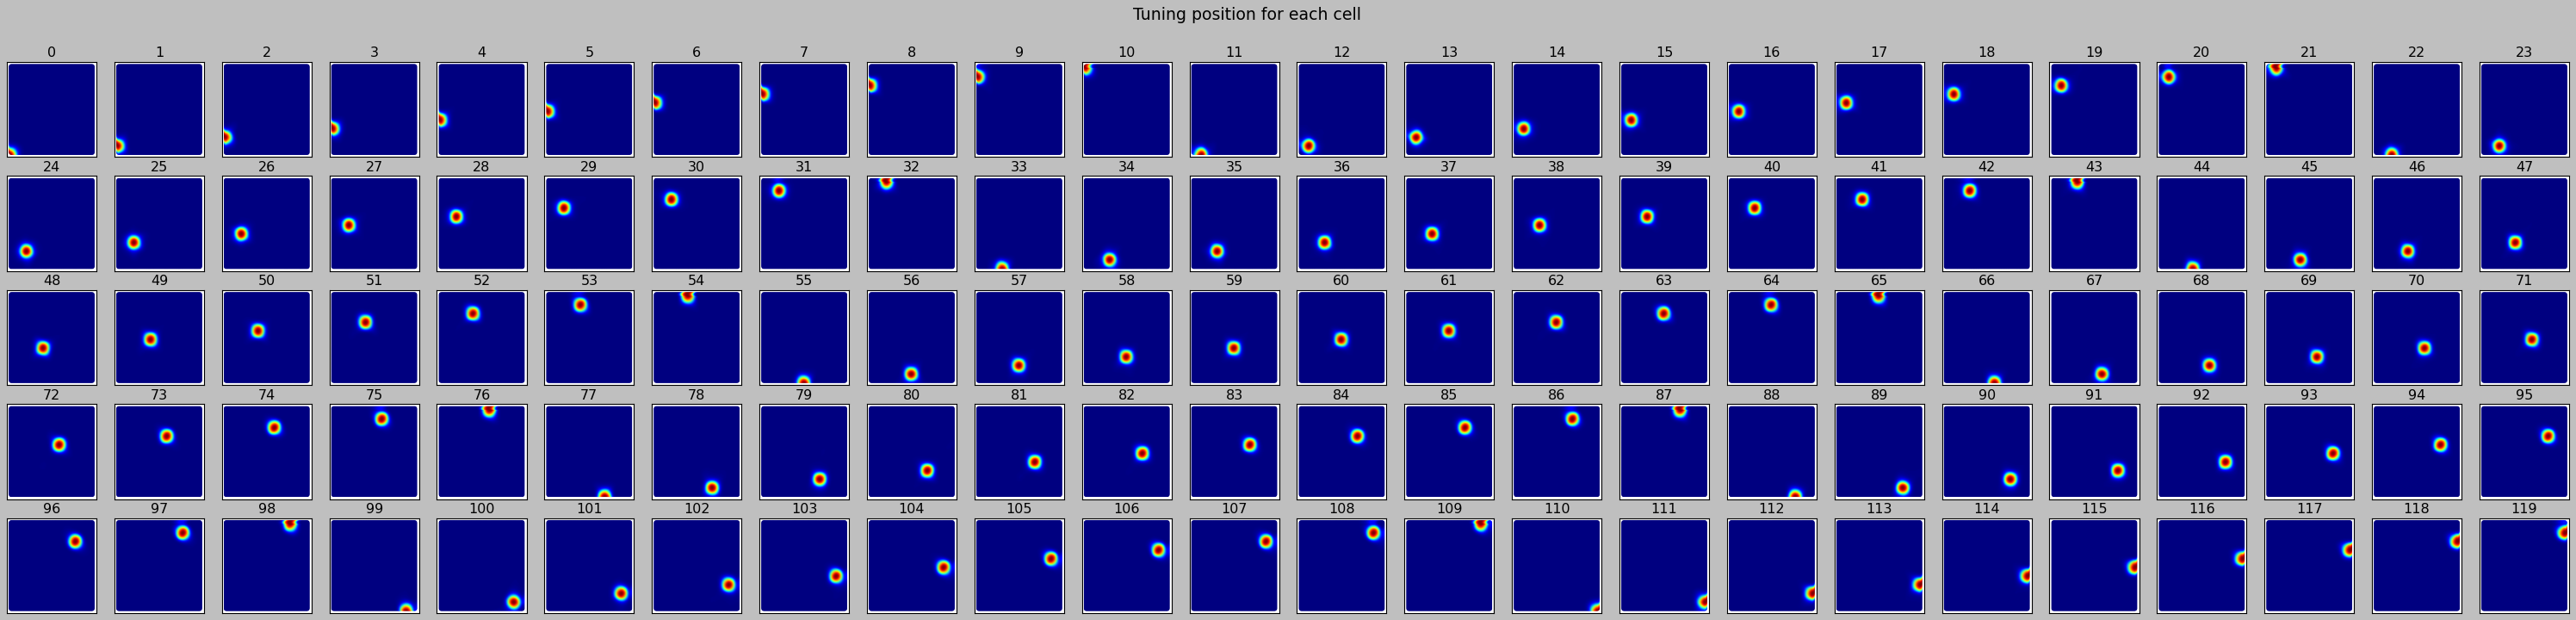

In [1514]:
nrows = 5
ncols = Nj // nrows
fig_0, axs = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
i = 0
for row in tqdm(axs):
    for ax in row:
        ax.scatter(input_array[:, 0], input_array[:, 1], c=preds[:, i], edgecolors='black', linewidths=0,)
        #ax.set_ylim((-0.01, 1.01))
        #ax.set_xlim((-0.01, 1.01))
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(f"{i}")
        i += 1
plt.suptitle("Tuning position for each cell", fontsize=17)
plt.show()

#### metric visualization

w1.shape=(32, 2)
w2.shape=(32, 32)
[[11. 20.]
 [20. 36.]]


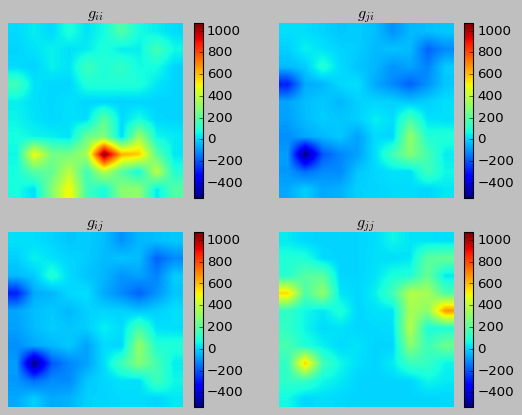

In [19]:
make_g(model=model, actp=actp, act=act)

---
simple input=target

In [64]:
""" traininig """
model = tm.DNN(hidden_dims=[2, 2])
act, actp = get_activation_function(activation)

model, losses, preds = tm.train_dnn(input_array=input_array.copy(),
                             target_array=input_array.copy(),
                             model=model, epochs=10_000)

Epoch: 9001, Loss: 0.000000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2230.51it/s]
2024-03-09 19:35:19 | Final loss: 0.000000


## Metric tensor - *study*
---

#### heatmaps

In [22]:
def heatmap(metric, N=10, du=1e-2):

    V = np.empty((N, N))
    for i, x in enumerate(np.linspace(0, 1, N)):
        for j, y in enumerate(np.linspace(0, 1, N)):
            # flip wrt y axis
            V[N-1-i, N-1-j] = np.linalg.det(metric(x,y))#((metric(x, y) @ np.array([[x], [y]])).T @ np.array([[x+du], [y]])).item()

    plt.imshow(V)
    plt.axis('off')
    plt.colorbar()
    plt.show()

def heatmap2(metric, N=10, du=1e-2):

    V = np.empty((4, N, N))
    for i, x in enumerate(np.linspace(0, 1, N)):
        for j, y in enumerate(np.linspace(0, 1, N)):
            # flip wrt y axis
            m = metric(x,y)
            V[0, N-1-i, N-1-j] = m[0, 0]
            V[1, N-1-i, N-1-j] = m[0, 1]
            V[2, N-1-i, N-1-j] = m[1, 0]
            V[3, N-1-i, N-1-j] = m[1, 1]

    #plt.suptitle(f"g={m}")
    plt.subplot(221)
    plt.imshow(V[0], vmin=0, vmax=1)
    plt.colorbar()
    plt.title("$g_{ii}$")
    plt.axis('off')
    
    plt.subplot(222)
    plt.imshow(V[1], vmin=0, vmax=1)
    plt.colorbar()
    plt.title("$g_{ji}$")
    plt.axis('off')
    
    plt.subplot(223)
    plt.imshow(V[2], vmin=0, vmax=1)
    plt.colorbar()
    plt.title("$g_{ij}$")
    plt.axis('off')
    
    plt.subplot(224)
    plt.imshow(V[3], vmin=0, vmax=1)
    plt.colorbar()
    plt.title("$g_{jj}$")
    plt.axis('off')
    
    plt.show()

heatmap2(G)

NameError: name 'G' is not defined

#### Fixed $g$

In [1276]:
from matplotlib.patches import Polygon

# Function to create a transformed grid
def transform_grid(ax, g, bounds=(0, 1, 0, 1), nlines=10):
    """
    Draw a transformed grid that simulates the effect of the metric tensor on space.
    """
    x_min, x_max, y_min, y_max = bounds
    x = np.linspace(x_min, x_max, nlines)
    y = np.linspace(y_min, y_max, nlines)
    
    # Calculate eigenvalues and eigenvectors to simulate the effect of the metric
    eigenvalues, eigenvectors = np.linalg.eig(g)
    scale_matrix = np.sqrt(eigenvalues) * eigenvectors
    
    # Plotting the original grid lines
    for xi in x:
        ax.plot([xi, xi], [y_min, y_max], 'k--', linewidth=0.5, alpha=0.5)
    for yi in y:
        ax.plot([x_min, x_max], [yi, yi], 'k--', linewidth=0.5, alpha=0.5)

    # Simulating the transformation effect of the metric tensor on the grid
    for xi in x:
        for yi in y:
            rect = np.array([[xi, xi, xi+1/(nlines-1), xi+1/(nlines-1)], [yi, yi+1/(nlines-1), yi+1/(nlines-1), yi]]).T
            transformed_rect = rect @ scale_matrix.T
            polygon = Polygon(transformed_rect, edgecolor='r', facecolor='none')
            ax.add_patch(polygon)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_aspect('equal')
    ax.set_title("Grid Transformed by Metric Tensor")



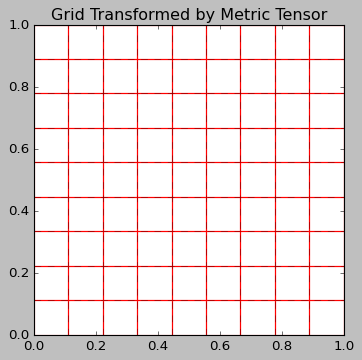

In [51]:
# Plot
def plot_g(g):
    fig, ax = plt.subplots(figsize=(5, 5))
    transform_grid(ax, g, bounds=(0, 1, 0, 1), nlines=10)
    plt.show()

plot_g(g=np.array([[1., 0.], [0., 1.]]))

#### Variable $g$

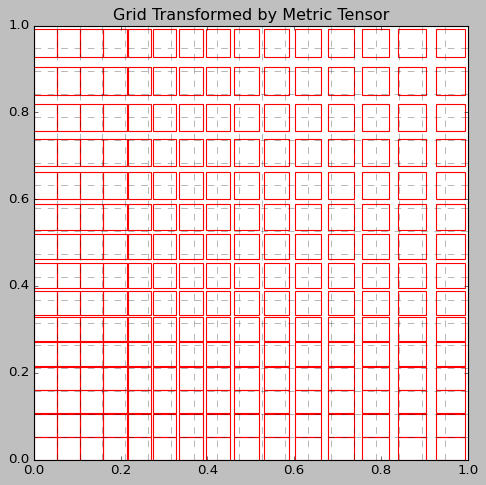

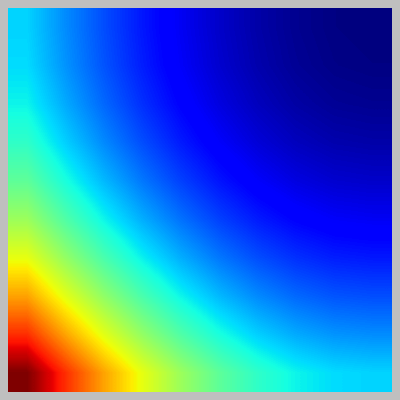

In [265]:
# Function to create a grid transformed by a variable metric
def transform_variable_grid(metric_func, bounds=(0, 1, 0, 1), nlines=10):

    #global index 
    x_min, x_max, y_min, y_max = bounds
    x = np.linspace(x_min, x_max, nlines)
    y = np.linspace(y_min, y_max, nlines)
    
    # Plotting the original grid lines
    fig, ax = plt.subplots(figsize=(7, 7))
    for xi in x:
        ax.plot([xi, xi], [y_min, y_max], 'k--', linewidth=0.5, alpha=0.5)
    for yi in y:
        ax.plot([x_min, x_max], [yi, yi], 'k--', linewidth=0.5, alpha=0.5)

    # Simulating the transformation effect of the variable metric tensor on the grid
    for xi in x[:-1]:
        for yi in y[:-1]:
            # Calculate the metric tensor for the center of the current cell
            g = metric_func(xi + 0.5/(nlines-1), yi + 0.5/(nlines-1))
            eigenvalues, eigenvectors = np.linalg.eig(g)
            scale_matrix = np.sqrt(eigenvalues) * eigenvectors
            scale_matrix = np.nan_to_num(scale_matrix, nan=0, posinf=0, neginf=0)

            #print(eigenvalues)
            
            # Define the cell corners and transform
            rect = np.array([[xi, xi, xi+1/(nlines-1), xi+1/(nlines-1)], 
                             [yi, yi+1/(nlines-1), yi+1/(nlines-1), yi]]).T
            transformed_rect = rect @ scale_matrix.T
            
            polygon = Polygon(transformed_rect, edgecolor='r', facecolor='none')
            ax.add_patch(polygon)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_aspect('equal')
    ax.set_title(f"Grid Transformed by Metric Tensor")
    plt.show()
    return transformed_rect


def variable_metric(x, y):
    """
    Example of a metric tensor that varies with x and y.
    For illustration, let's define a simple variation with x and y.
    """
    return np.array([[1 + x**2, 0.*y], [0.*y, 1 + y**2]])

def euc_metric(x, y):
    return np.eye(2)
    
# Plot
_ = transform_variable_grid(variable_metric, bounds=(0, 1, 0, 1), nlines=20)
#_ = transform_variable_grid(euc_metric, bounds=(0, 1, 0, 1), nlines=20)

heatmap(variable_metric)

#### loaded model $g$

In [70]:
model = mm.load_model(name='pcnn_1')
layer = it.PlaceLayer(N=13**2, sigma=0.0075)

logger(model)
logger(layer)

2024-02-28 22:55:39 | /Users/daniekru/Research/lab/PCNN/cache
2024-02-28 22:55:39 | ['dataset_1.json', '5_best_pcnn_bpc.json', '8_best_pcnn_bpc.json', '11_best_hl.json', '6_best_pcnn_bpc.json', '3_best_pcnn_bpc.json', '10_best_pcnn_bpc.json', '2_best_pcnn_bpc.json', '11_best_pcnn_bpc.json', '7_best_pcnn_bpc.json', '12_best_hl.json', 'pcnn_1.json', '4_best_pcnn_bpc.json', '9_best_pcnn_bpc.json']
2024-02-28 22:55:39 | Model loaded from pcnn_1.json
2024-02-28 22:55:39 | PCNNetwork(N=100, Nj=169) [UsI7n]
2024-02-28 22:55:39 | Layer(N=169, kind=`place`)


In [224]:
index = 0

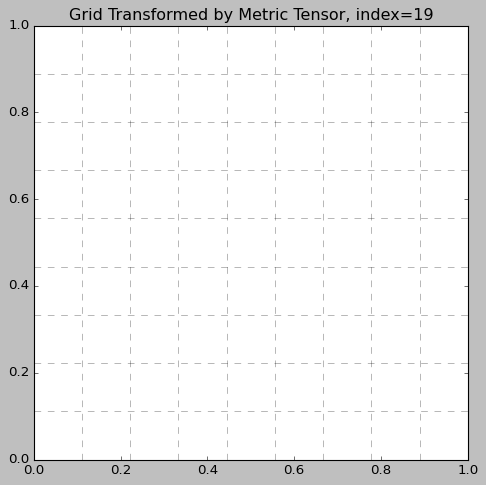

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [244]:
print(transform_variable_grid(G, bounds=(0, 1, 0, 1), nlines=10))
index += 1

In [ ]:
plot_g(g=G(w=model.W_final, ))

#### Trained model $g$

In [345]:
sig = lambda x: 1/(1+np.exp(-x))
sigp = lambda x: sig(x)*(1-sig(x))

In [348]:
wdict = model.state_dict()
wd = {}
wd['w1'] = wdict['layers.0.weight'].numpy()
wd['b1'] = wdict['layers.0.bias'].numpy().reshape(-1, 1)
wd['w2'] = wdict['layers.1.weight'].numpy()
wd['b2'] = wdict['layers.1.bias'].numpy().reshape(-1, 1)
print(wd['w1'].shape)
print(wd['w2'].shape)

(2, 2)
(2, 2)


In [275]:
""" no output sigmoid """
def gii(x, w=wd):
    z1 = w['w1'] @ x + w['b1']
    z2 = w['w2'] @ sig(z1) + w['b2']

    #return w['w2'].T @ sigp(z2)

    return ((w['w1'].T @ (sigp(z1) * (w['w2'].T @ z2))).T @ (w['w1'].T @ (sigp(z1) * (w['w2'].T @ z2)))).item()

def gij(x1, x2, w=wd):

    z11 = w['w1'] @ x1 + w['b1']
    z21 = w['w2'] @ sig(z11) + w['b2']

    z12 = w['w1'] @ x2 + w['b1']
    z22 = w['w2'] @ sig(z12) + w['b2']

    return ((w['w1'].T @ (sigp(z11) * (w['w2'].T @ z21))).T @ (w['w1'].T @ (sigp(z12) * (w['w2'].T @ z22)))).item()

def G(x, y, w=wd):

    x1 = np.array([x, 0.], dtype=np.float32).reshape(-1, 1)
    x2 = np.array([0., y], dtype=np.float32).reshape(-1, 1)
    
    return np.array(
        [[gii(x=x1), gij(x1=x1, x2=x2)],
         [gij(x1=x2, x2=x1), gii(x=x2)]]
    )

G(x=1, y=1.).shape
#gii(x=np.array([[1], [1]], dtype=np.float32)).shape

(2, 2)

In [392]:
""" activations """
sig = lambda x: 1/(1+np.exp(-x))
sigp = lambda x: sig(x)*(1-sig(x))

""" load model params """
wdict = model.state_dict()
wd = {}
wd['w1'] = wdict['layers.0.weight'].numpy()
wd['b1'] = wdict['layers.0.bias'].numpy().reshape(-1, 1)
wd['w2'] = wdict['layers.1.weight'].numpy()
wd['b2'] = wdict['layers.1.bias'].numpy().reshape(-1, 1)

""" metric calc """
def gii(x, w=wd):
    z1 = w['w1'] @ x + w['b1']
    z2 = w['w2'] @ sig(z1) + w['b2']

    #return w['w2'].T @ sigp(z2)

    return ((w['w1'].T @ (sigp(z1) * (w['w2'].T @ sigp(z2)))).T @ (w['w1'].T @ (sigp(z1) * (w['w2'].T @ sigp(z2))))).item()

def gij(x1, x2, w=wd):

    z11 = w['w1'] @ x1 + w['b1']
    z21 = w['w2'] @ sig(z11) + w['b2']

    z12 = w['w1'] @ x2 + w['b1']
    z22 = w['w2'] @ sig(z12) + w['b2']

    return ((w['w1'].T @ (sigp(z11) * (w['w2'].T @ sigp(z21)))).T @ (w['w1'].T @ (sigp(z12) * (w['w2'].T @ sigp(z22))))).item()

def G(x, y, w=wd):

    #x1 = np.array([x, 0.], dtype=np.float32).reshape(-1, 1)
    #x2 = np.array([0., y], dtype=np.float32).reshape(-1, 1)
    x1 = np.array([1, 0.], dtype=np.float32).reshape(-1, 1)
    #
    x2 = np.array([0., 1], dtype=np.float32).reshape(-1, 1)
    
    return np.array(
        [[gii(x=x1), gij(x1=x1, x2=x2)],
         [gij(x1=x2, x2=x1), gii(x=x2)]]
    )

G(x=1, y=1.).shape
#gii(x=np.array([[1], [1]], dtype=np.float32)).shape

(2, 2)

In [174]:
gii(x=np.array([[1], [1]], dtype=np.float32)).shape

(2, 2)

In [366]:
G(x=1, y=1.)

array([[0.69502646, 0.66462147],
       [0.66462147, 0.63555324]])

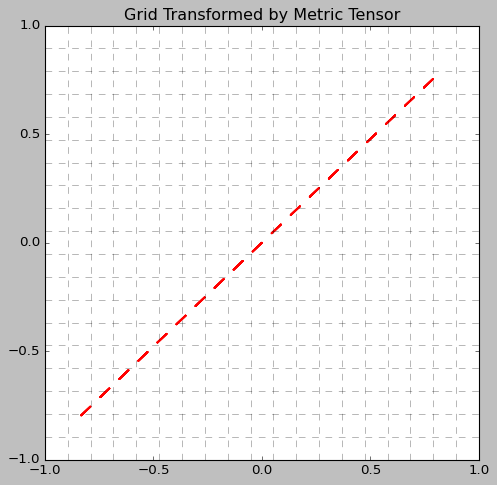

In [369]:
_ = transform_variable_grid(G, bounds=(-1, 1, -1, 1), nlines=20)

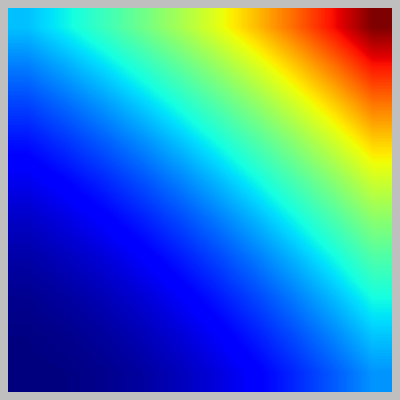

In [580]:
heatmap(G)

---
#### Simple case

In [1309]:
""" training PC """
activation = 'sigmoid'
act, actp = get_activation_function(activation)
model = tm.DNN(hidden_dims=[16, Nj], activation=activation)

model, losses, preds = tm.train_dnn(input_array=input_array.copy(),
                             target_array=target_array.copy(),
                             model=model, epochs=20_000)

Epoch: 18001, Loss: 0.000415: 100%|███████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 879.48it/s]
2024-03-08 14:20:54 | Final loss: 0.000182


In [32]:
""" training XY """
activation = 'tanh'
act, actp = get_activation_function(activation)
model = tm.DNN(hidden_dims=[32, 2], activation=activation)

model, losses, preds = tm.train_dnn(input_array=input_array.copy(),
                             target_array=input_array.copy(),
                             model=model, epochs=2_000)

Epoch: 1801, Loss: 0.000000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1396.75it/s]
2024-03-09 19:24:52 | Final loss: 0.000000


In [ ]:
""" save model """

#### base

In [1295]:
print("w:\n", np.around(w, 3))
z = np.array([[1.], [0.]])
print("z:\n", z)
print(np.around((actp(z) * w), 2))
#np.around((actp(z).T * w) @ (actp(z).T * w).T, 3)

w:
 [[ 4.944 -0.   ]
 [-0.     4.943]]
z:
 [[1.]
 [0.]]
[[ 0.97 -0.  ]
 [-0.    1.24]]


---

#### **1-layer**

[[ 0.458 -0.058  0.184 -0.088 -0.201]
 [-0.058  0.443  0.434  0.453  0.011]
 [ 0.184  0.434  0.555  0.429 -0.096]
 [-0.088  0.453  0.429  0.465  0.023]
 [-0.201  0.011 -0.096  0.023  0.088]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 2)

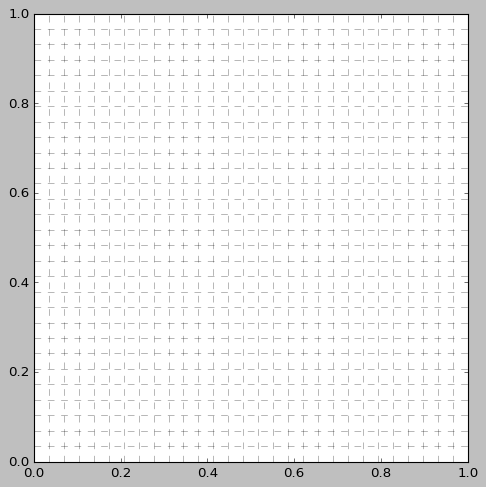

In [1346]:
""" load model params """
wdict = model.state_dict()
w = wdict['layers.0.weight'].numpy()
b = wdict['layers.0.bias'].numpy().reshape(-1, 1)

""" metric calc """

def G(x, y, w=w, b=b):

    x = np.array([[x], [y]])
    #print(f"{x.shape}")
    #print(f"{w.shape}")
    
    return np.around((actp(x).T * w) @ (actp(x).T * w).T, 3)

print(G(x=1, y=1.))

_ = transform_variable_grid(G, bounds=(0, 1, 0, 1), nlines=30)

#### **2-layers**

w1.shape=(5, 2)
w2.shape=(2, 5)
[[ 0.961 -0.009]
 [-0.009  1.051]]


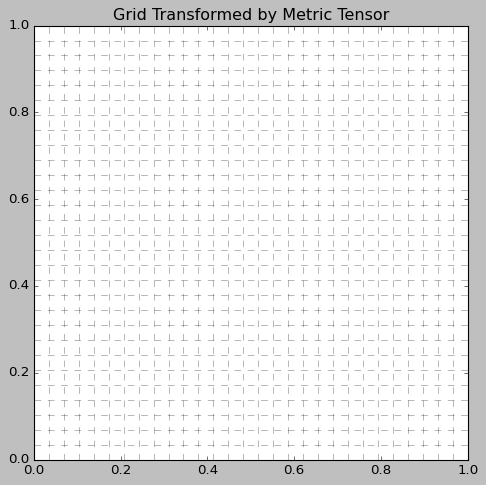

In [1367]:
""" load model params """
wdict = model.state_dict()
w1 = wdict['layers.0.weight'].numpy()
b1 = wdict['layers.0.bias'].numpy().reshape(-1, 1)
w2 = wdict['layers.1.weight'].numpy()
b2 = wdict['layers.1.bias'].numpy().reshape(-1, 1)

print(f"{w1.shape=}")
print(f"{w2.shape=}")


""" metric calc """

def G(x, y, w1=w1, w2=w2, b1=b1, b2=b2):
    
    return np.around((w2 @ w1) @ (w2 @ w1).T, 3)

print(G(x=1, y=1.))

_ = transform_variable_grid(G, bounds=(0, 1, 0, 1), nlines=30)


#### **2 layers + activation**

w1.shape=(32, 2)
w2.shape=(2, 32)
[[0. 0.]
 [0. 0.]]


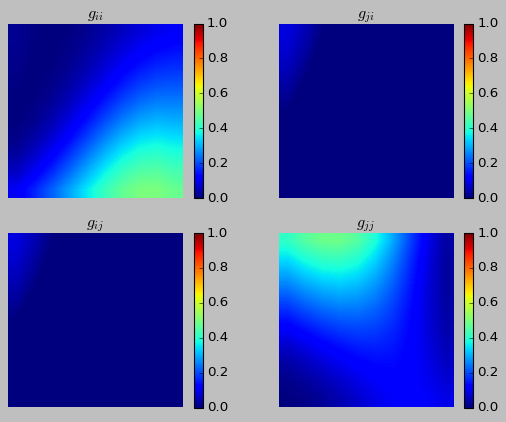

In [31]:
""" load model params """
def make_g(model, actp, act):
    wdict = model.state_dict()
    w1 = wdict['layers.0.weight'].numpy()
    b1 = wdict['layers.0.bias'].numpy().reshape(-1, 1)
    w2 = wdict['layers.1.weight'].numpy()
    b2 = wdict['layers.1.bias'].numpy().reshape(-1, 1)
    
    print(f"{w1.shape=}")
    print(f"{w2.shape=}")
    
    
    """ metric calc """
    
    def G(x, y, w1=w1, w2=w2, b1=b1, b2=b2):
    
        x1 = np.array([[x], [y]])    
        x2 = w1 @ x1 + b1
        x3 = w2 @ act(x2) + b2
    
        return ((actp(x2).T @ w1).T @ (actp(x3).T @ w2)) @ ((actp(x2).T @ w1).T @ (actp(x3).T @ w2)).T
        #return ((actp(x3) * w2) @ (actp(x2) * w1)).T @ ((actp(x3) * w2) @ (actp(x2) * w1)).T
        #return np.around(((actp(x2) @ (actp(x3).T @ w2)) @ w1).T @ ((actp(x2) @ (actp(x3).T @ w2)) @ w1), 3)
    
    print(np.around(G(x=1, y=1.))) 
    
    #_ = transform_variable_grid(G, bounds=(-1, 1, -1, 1), nlines=30)
    heatmap2(G)

make_g(model=model, actp=actp, act=act)

w1.shape=(64, 2)
w2.shape=(25, 64)
(2, 2)


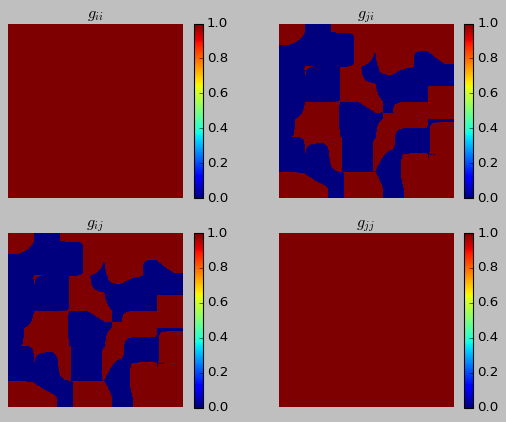

In [1496]:
""" load model params """
wdict = model.state_dict()
w1 = wdict['layers.0.weight'].numpy()
b1 = wdict['layers.0.bias'].numpy().reshape(-1, 1)
w2 = wdict['layers.1.weight'].numpy()
b2 = wdict['layers.1.bias'].numpy().reshape(-1, 1)

print(f"{w1.shape=}")
print(f"{w2.shape=}")


""" metric calc """

def G(x, y, w1=w1, w2=w2, b1=b1, b2=b2):

    x1 = np.array([[x], [y]])    
    x2 = w1 @ x1 + b1
    x3 = w2 @ act(x2) + b2

    return ((actp(x2).T @ w1).T @ (actp(x3).T @ w2)) @ ((actp(x2).T @ w1).T @ (actp(x3).T @ w2)).T
    #return ((actp(x3) * w2) @ (actp(x2) * w1)).T @ ((actp(x3) * w2) @ (actp(x2) * w1)).T
    #return np.around(((actp(x2) @ (actp(x3).T @ w2)) @ w1).T @ ((actp(x2) @ (actp(x3).T @ w2)) @ w1), 3)

print(np.around(G(x=1, y=1.)).shape) 

#_ = transform_variable_grid(G, bounds=(-1, 1, -1, 1), nlines=30)
heatmap2(G)

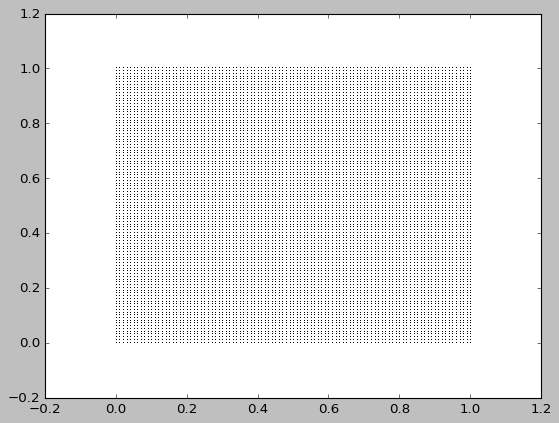

In [1479]:
plt.plot(preds[:, 0], preds[:, 1], 'k,');

[[ 9.993912  -5.8920894]
 [-5.8920894 15.060753 ]]


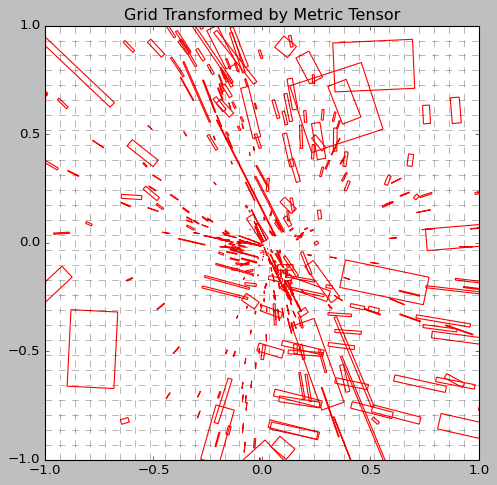

/var/folders/77/b66qkr5d21l_3nnw6f563fw80000gp/T/ipykernel_94984/3617024420.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


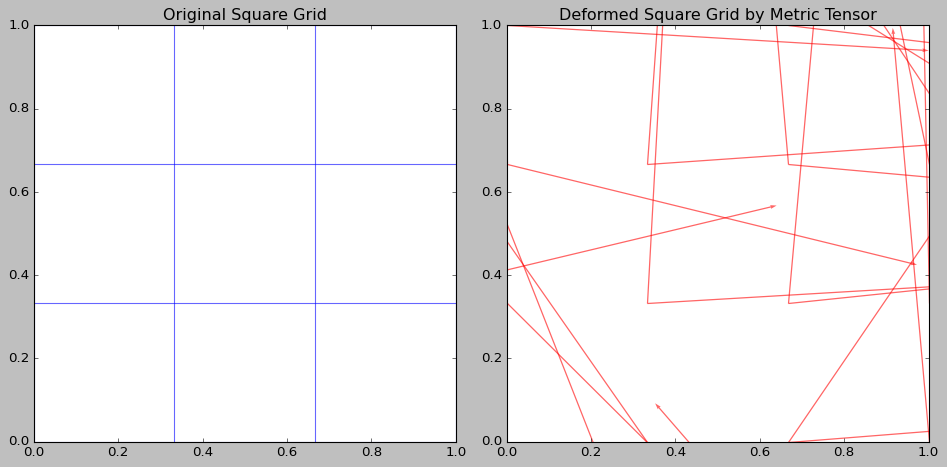

In [1508]:
# Load model parameters
wdict = model.state_dict()
w1 = wdict['layers.0.weight'].numpy()
b1 = wdict['layers.0.bias'].numpy().reshape(-1, 1)
w2 = wdict['layers.1.weight'].numpy()
b2 = wdict['layers.1.bias'].numpy().reshape(-1, 1)

def G(x, y):
    # Prepare input
    input_vector = np.array([[x], [y]], dtype=np.float32)
    
    # First layer forward pass
    z1 = np.dot(w1, input_vector) + b1
    a1 = act(z1)
    d1 = actp(z1)
    
    # Second layer forward pass
    z2 = np.dot(w2, a1) + b2
    d2 = actp(z2)
    
    # Computing the Jacobian for the whole network
    # Second layer contribution to the Jacobian, taking into account the activation derivative
    J2 = np.diag(d2.flatten()) @ w2
    
    # First layer contribution, incorporating the second layer's effect
    J1 = J2 @ (np.diag(d1.flatten()) @ w1)
    
    # The metric tensor is computed as the Gram matrix of the Jacobian: G = J^T * J
    return np.dot(J1.T, J1)
    
print(G(x=0, y=0.))
_ = transform_variable_grid(G, bounds=(-1, 1, -1, 1), nlines=30)
visualize_square_grid(G, 10)


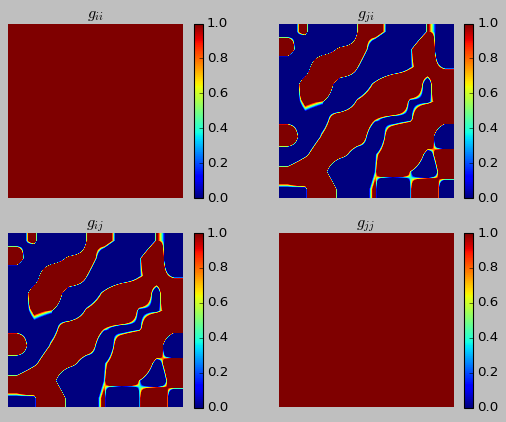

In [1509]:
heatmap2(G)

/var/folders/77/b66qkr5d21l_3nnw6f563fw80000gp/T/ipykernel_94984/3617024420.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


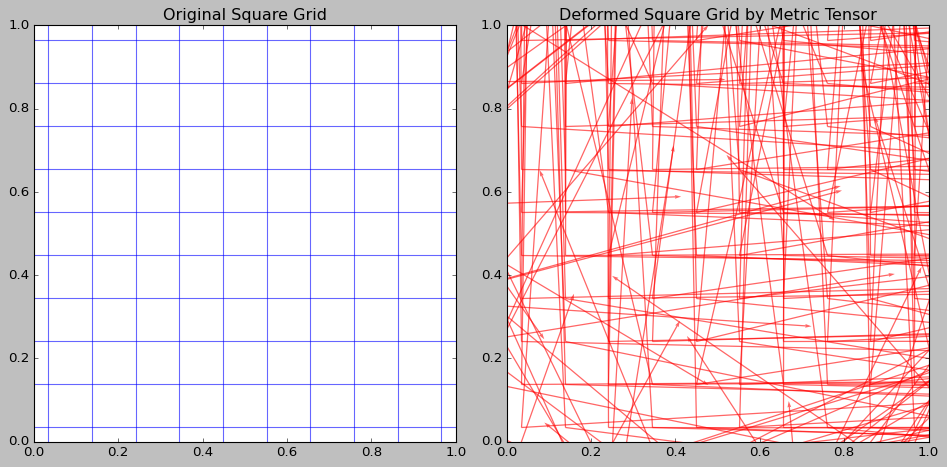

In [1510]:
def visualize_square_grid(G, granularity):
    # Generate a square grid
    x = np.linspace(-1, 2, granularity)
    y = np.linspace(-1, 2, granularity)
    X, Y = np.meshgrid(x, y)

    # Initialize vectors for deformation
    Ux = np.zeros_like(X)
    Vx = np.zeros_like(Y)
    Uy = np.zeros_like(X)
    Vy = np.zeros_like(Y)

    # Apply the metric tensor to both unit vectors at each point in the grid
    for i in range(granularity):
        for j in range(granularity):
            # Get the metric tensor at (x, y)
            g = G(X[i, j], Y[i, j])
            # Transform unit vectors in x and y directions
            vector_x = np.dot(g, np.array([1, 0]))  # Transform a unit vector in x-direction
            vector_y = np.dot(g, np.array([0, 1]))  # Transform a unit vector in y-direction
            Ux[i, j], Vx[i, j] = vector_x / np.linalg.norm(vector_x)  # Normalize for visualization
            Uy[i, j], Vy[i, j] = vector_y / np.linalg.norm(vector_y)  # Normalize for visualization

    # Plot the original and deformed grids
    plt.figure(figsize=(12, 6))

    # Original grid
    plt.subplot(1, 2, 1)
    for i in range(granularity):
        plt.plot(X[i, :], Y[i, :], 'b', alpha=0.6)  # Horizontal lines
        plt.plot(X[:, i], Y[:, i], 'b', alpha=0.6)  # Vertical lines
    plt.title('Original Square Grid')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Deformed grid
    plt.subplot(1, 2, 2)
    for i in range(granularity):
        for j in range(granularity):
            # Plot the deformed vectors representing the grid lines
            plt.quiver(X[i, j], Y[i, j], Ux[i, j], Vx[i, j], angles='xy', scale_units='xy', scale=1, color='r', alpha=0.6, width=0.003)
            plt.quiver(X[i, j], Y[i, j], Uy[i, j], Vy[i, j], angles='xy', scale_units='xy', scale=1, color='r', alpha=0.6, width=0.003)
    plt.title('Deformed Square Grid by Metric Tensor')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Run the visualization for a square grid with specified granularity
def metric(x, y):
    return np.array([[1, 0.0],
                     [0.0, 1]])
visualize_square_grid(G, 30)


### 3-layers + activation

In [17]:
""" load model params """
def make_g3(model, actp, act):
    wdict = model.state_dict()
    w1 = wdict['layers.0.weight'].numpy()
    b1 = wdict['layers.0.bias'].numpy().reshape(-1, 1)
    w2 = wdict['layers.1.weight'].numpy()
    b2 = wdict['layers.1.bias'].numpy().reshape(-1, 1)
    w3 = wdict['layers.2.weight'].numpy()
    b3 = wdict['layers.2.bias'].numpy().reshape(-1, 1)
    
    print(f"{w1.shape=}")
    print(f"{w2.shape=}")
    print(f"{w3.shape=}")
    
    """ metric calc """
    
    def G3(x, y, w1=w1, w2=w2, w3=w3, b1=b1, b2=b2, b3=b3):
    
        x1 = np.array([[x], [y]])    
        x2 = w1 @ x1 + b1
        x3 = w2 @ act(x2) + b2
        x4 = w3 @ act(x3) + b3
        print(f"\n{x1.shape=}")
        print(f"{x2.shape=}")
        print(f"{x3.shape=}")
        print(f"{x4.shape=}\n")

        return  (actp(x4).T @ w3).T @ (actp(x3).T @ w2)
        return ((actp(x2).T @ w1).T @ (actp(x3).T @ w2)) #@ ((actp(x2).T @ w1).T @ (actp(x3).T @ w2)).T
        return (((((actp(x4).T @ w3).T * actp(x3)).T @ w2) * actp(x2)).T @ w1).T @ (((((actp(x4).T @ w3).T * actp(x3)).T @ w2) * actp(x2)).T @ w1)
        return (((actp(x2).T @ w1).T @ ((actp(x3).T @ w2).T @ (actp(x4).T @ w3))).T)# @ (((actp(x2).T @ w1).T @ (actp(x3).T @ w2)).T @ (actp(x3).T @ w2)).T
        #return ((actp(x3) * w2) @ (actp(x2) * w1)).T @ ((actp(x3) * w2) @ (actp(x2) * w1)).T
        #return np.around(((actp(x2) @ (actp(x3).T @ w2)) @ w1).T @ ((actp(x2) @ (actp(x3).T @ w2)) @ w1), 3)
    
    print(np.around(G3(x=1, y=1.)).shape) 
    
    #_ = transform_variable_grid(G, bounds=(-1, 1, -1, 1), nlines=30)
    #heatmap2(G3)

#make_g3(model=model, actp=actp, act=act)

In [202]:
""" training XY """
activation = 'tanh'
act, actp = get_activation_function(activation)
model = tm.DNN(hidden_dims=[4, 3, 2], activation=activation)

model, losses, preds = tm.train_dnn(input_array=input_array.copy(),
                             target_array=input_array.copy(),
                             model=model, epochs=1_000)

make_g3(model=model, actp=actp, act=act)

Epoch: 901, Loss: 0.000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1270.35it/s]
2024-03-09 20:26:38 | Final loss: 0.000000


w1.shape=(4, 2)
w2.shape=(3, 4)
w3.shape=(2, 3)

x1.shape=(2, 1)
x2.shape=(4, 1)
x3.shape=(3, 1)
x4.shape=(2, 1)

(1, 4)


## ***Jax*** playground
---

In [4]:
!pip install jax


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
from timeit import timeit

In [8]:
key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [9]:
size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

105 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

108 ms ± 4.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
#@jit
def dot(x, y):
    #print('dotting')
    return (x @ y).flatten()

x = np.random.randn(5, 3)
y = np.random.randn(3, 1)

%timeit dot(x,y)


%timeit dot(x,y)


901 ns ± 24.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
895 ns ± 4.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [58]:
@jit
def dot(x, y):
    #print('dotting')
    return (x @ y).flatten()

x = np.random.randn(500, 300)
y = np.random.randn(300, 1)

%timeit dot(x,y)


%timeit dot(x,y)


31 µs ± 81.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
30.7 µs ± 225 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Play

- define a variable about the temperature
- print 'cold' if its below zero
-       'warm'

In [29]:
number = -224

if number > 0:
    feature = 'greater than zero'
elif number == 0:
    feature = 'zero'
else:
    feature = 'less than zero'

print(feature)

less than zero
